1. Get the time series for the following cryptocurrencies from cryptowat.ch starting from 2021-11-22, hourly data
ETH

In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from pandas.plotting import autocorrelation_plot

def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [2]:
def get_data_kk(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT']

In [4]:
dfs = [get_data(token) for token in tokens]

In [5]:
dfs.append(get_data_kk('FLOW'))

In [6]:
df_base = pd.concat(dfs)
df = df_base

2. Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [7]:
df.groupby('token')['volumeUSD'].sum().to_frame().sort_values('volumeUSD', ascending=False)

,volumeUSD
token,
ETH,2.696763e+10
SOL,8.946492e+09
AVAX,5.049458e+09
USDT,2.478069e+09
FLOW,1.025786e+08


3. Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

In [8]:
dfs_close = dfs[0].set_index('ts')['close'].rename(f'close_{tokens[0]}').to_frame().join(
    dfs[1].set_index('ts')['close'].rename(f'close_{tokens[1]}').to_frame()
)
dfs_close['ETH_SOL_ratio'] = dfs_close['close_ETH']/dfs_close['close_SOL']
dfs_close = dfs_close.reset_index()

In [9]:
df = df.join(dfs_close['ETH_SOL_ratio'])
df.set_index('ts')

,open,high,low,close,volume,volumeUSD,token,ETH_SOL_ratio
ts,,,,,,,,
2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694
...,...,...,...,...,...,...,...,...
2021-12-23 11:00:00,3931.5600,3937.7800,3916.0200,3933.0200,8.698137e+02,3.417544e+06,ETH,21.990607
2021-12-23 11:00:00,179.1000,179.6200,178.1100,178.8500,6.947333e+03,1.242541e+06,SOL,21.990607
2021-12-23 11:00:00,119.4400,119.5800,118.3000,118.8600,8.511490e+03,1.011273e+06,AVAX,21.990607


4. Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm

In [10]:
df.rename(
    columns={
        'volume':'volumeBase',
        'volumeUSD':'volumeTerm'
    }
)

,ts,open,high,low,close,volumeBase,volumeTerm,token,ETH_SOL_ratio
0,2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
0,2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
0,2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
0,2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
0,2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694
...,...,...,...,...,...,...,...,...,...
755,2021-12-23 11:00:00,3931.5600,3937.7800,3916.0200,3933.0200,8.698137e+02,3.417544e+06,ETH,21.990607
755,2021-12-23 11:00:00,179.1000,179.6200,178.1100,178.8500,6.947333e+03,1.242541e+06,SOL,21.990607
755,2021-12-23 11:00:00,119.4400,119.5800,118.3000,118.8600,8.511490e+03,1.011273e+06,AVAX,21.990607
755,2021-12-23 11:00:00,1.0003,1.0004,1.0003,1.0004,5.192754e+05,5.194657e+05,USDT,21.990607


5. create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns)

In [11]:
tokenList = df.token.unique()
df_close = dfs[0][['ts']]
i = 0
for token in tokenList:
    df_close = df_close.join(dfs[i]['close']).rename(columns={'close':token})
    i = i+1
df_close.set_index('ts')

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-23 07:00:00,3962.72,180.060,120.65,1.0004,8.749
2021-12-23 08:00:00,3911.83,177.950,117.72,1.0003,8.685
2021-12-23 09:00:00,3931.25,179.940,119.31,1.0003,8.737


6. calculate the hour by hour log return of the close price of each token (return is calculated by np.log(price_t / price_{t-
1}))

In [12]:
df_return = df_close['ts'].to_frame()
for token in tokenList:
    df_return[token + '_log_return'] = np.log(df_close[token]/df_close[token].shift(1))
df_return.set_index('ts')

,ETH_log_return,SOL_log_return,AVAX_log_return,USDT_log_return,FLOW_log_return
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
...,...,...,...,...,...
2021-12-23 07:00:00,0.003960,0.003951,0.004569,0.0000,0.000915
2021-12-23 08:00:00,-0.012925,-0.011788,-0.024585,-0.0001,-0.007342
2021-12-23 09:00:00,0.004952,0.011121,0.013416,0.0000,0.005969


[Stretch] calculate the correlation of the tokens using the table above

In [13]:
return_corr = df_return.corr()
return_corr

,ETH_log_return,SOL_log_return,AVAX_log_return,USDT_log_return,FLOW_log_return
ETH_log_return,1.000000,0.757183,0.655550,-0.080844,0.570402
SOL_log_return,0.757183,1.000000,0.646366,0.106205,0.471563
AVAX_log_return,0.655550,0.646366,1.000000,0.019888,0.411239
USDT_log_return,-0.080844,0.106205,0.019888,1.000000,-0.170803
FLOW_log_return,0.570402,0.471563,0.411239,-0.170803,1.000000


[Stretch] visualize the correlation in a matplpotlib plot

<AxesSubplot:>

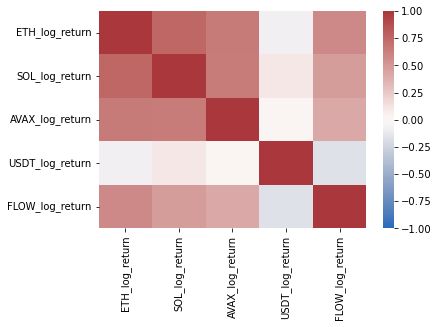

In [14]:
sns.heatmap(return_corr, vmin=-1, vmax=1, cmap='vlag')